# Word Vectorization - Lab

## Introduction

In this lab, you'll tokenize and vectorize text documents, create and use a bag of words, and identify words unique to individual documents using TF-IDF vectorization. 


## Objectives

In this lab you will:  

- Implement tokenization and count vectorization from scratch 
- Implement TF-IDF from scratch 
- Use dimensionality reduction on vectorized text data to create and interpret visualizations 

## Let's get started!

Run the cell below to import everything necessary for this lab.  

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
np.random.seed(0)

### Our Corpus

In this lab, we'll be working with 20 different documents, each containing song lyrics from either Garth Brooks or Kendrick Lamar albums.  

The songs are contained within the `data` subdirectory, contained within the same folder as this lab.  Each song is stored in a single file, with files ranging from `song1.txt` to `song20.txt`.  

To make it easy to read in all of the documents, use a list comprehension to create a list containing the name of every single song file in the cell below. 

In [6]:
filenames = [f'data/song{i}.txt' for i in range(1,21)]
filenames

['data/song1.txt',
 'data/song2.txt',
 'data/song3.txt',
 'data/song4.txt',
 'data/song5.txt',
 'data/song6.txt',
 'data/song7.txt',
 'data/song8.txt',
 'data/song9.txt',
 'data/song10.txt',
 'data/song11.txt',
 'data/song12.txt',
 'data/song13.txt',
 'data/song14.txt',
 'data/song15.txt',
 'data/song16.txt',
 'data/song17.txt',
 'data/song18.txt',
 'data/song19.txt',
 'data/song20.txt']

Next, create an empty DataFrame called `songs_df`.  As we read in the songs and store and clean them, we'll store them in this DataFrame.

In [3]:
# eek, but thats bad practice.  I'll instead create a dict and the change it to a dataframe.
songs_df = None
songs_dict = {}

Next, let's import a single song to see what our text looks like so that we can make sure we clean and tokenize it correctly. 

In the cell below, read in and print out the lyrics from `song11.txt`.  Use vanilla Python, no pandas needed.  

In [10]:
# Import and print song11.txt

f = open('data/song11.txt', 'r')
song = f.read() 
print(song)

[Kendrick Lamar:]
Love, let's talk about love
Is it anything and everything you hoped for?
Or do the feeling haunt you?
I know the feeling haunt you
[SZA:]
This may be the night that my dreams might let me know
All the stars approach you, all the stars approach you, all the stars approach you
This may be the night that my dreams might let me know
All the stars are closer, all the stars are closer, all the stars are closer
[Kendrick Lamar:]
Tell me what you gon' do to me
Confrontation ain't nothin' new to me
You can bring a bullet, bring a sword, bring a morgue
But you can't bring the truth to me
Fuck you and all your expectations
I don't even want your congratulations
I recognize your false confidence
And calculated promises all in your conversation
I hate people that feel entitled
Look at me crazy 'cause I ain't invite you
Oh, you important?
You the moral to the story? You endorsin'?
Motherfucker, I don't even like you
Corrupt a man's heart with a gift
That's how you find out who you 

### Tokenizing our Data

Before we can create a bag of words or vectorize each document, we need to clean it up and split each song into an array of individual words. Computers are very particular about strings. If we tokenized our data in its current state, we would run into the following problems:

- Counting things that aren't actually words.  In the example above, `"[Kendrick]"` is a note specifying who is speaking, not a lyric contained in the actual song, so it should be removed.  
- Punctuation and capitalization would mess up our word counts. To the Python interpreter, `love`, `Love`, `Love?`, and `Love\n` are all unique words, and would all be counted separately.  We need to remove punctuation and capitalization, so that all words will be counted correctly. 

Consider the following sentences from the example above:

`"Love, let's talk about love\n", 'Is it anything and everything you hoped for?\n'`

After tokenization, this should look like:

`['love', 'let's', 'talk', 'about', 'love', 'is', 'it', 'anything', 'and', 'everything', 'you', 'hoped', 'for']`

Tokenization is pretty tedious if we handle it manually, and would probably make use of regular expressions, which is outside the scope of this lab. In order to keep this lab moving, we'll use a library function to clean and tokenize our data so that we can move onto vectorization.  

Tokenization is a required task for just about any Natural Language Processing (NLP) task, so great industry-standard tools exist to tokenize things for us, so that we can spend our time on more important tasks without getting bogged down hunting every special symbol or punctuation in a massive dataset. For this lab, we'll make use of the tokenizer in the amazing `nltk` library, which is short for _Natural Language Tool Kit_.

**_NOTE:_** NLTK requires extra installation methods to be run the first time certain methods are used.  If `nltk` throws you an error about needing to install additional packages, follow the instructions in the error message to install the dependencies, and then rerun the cell.  

Before we tokenize our songs, we'll do only a small manual bit of cleaning. In the cell below, write a function that allows us to remove lines that have `['artist names']` in it, to ensure that our song files contain only lyrics that are actually in the song. For the lines that remain, make every word lowercase, remove newline characters `\n`, and all the following punctuation marks: `",.'?!"`

Test the function on `test_song` to show that it has successfully removed `'[Kendrick Lamar:]'` and other instances of artist names from the song and returned it.  

In [22]:
import re

def clean_song(song):
    song = re.sub('\[.*]|[,.\'?!]', '', song)
    song = song.replace('\n', ' ').strip()
    song = song.lower()
    return song
song_without_brackets = clean_song(song)
print(song_without_brackets)

love lets talk about love is it anything and everything you hoped for or do the feeling haunt you i know the feeling haunt you  this may be the night that my dreams might let me know all the stars approach you all the stars approach you all the stars approach you this may be the night that my dreams might let me know all the stars are closer all the stars are closer all the stars are closer  tell me what you gon do to me confrontation aint nothin new to me you can bring a bullet bring a sword bring a morgue but you cant bring the truth to me fuck you and all your expectations i dont even want your congratulations i recognize your false confidence and calculated promises all in your conversation i hate people that feel entitled look at me crazy cause i aint invite you oh you important you the moral to the story you endorsin motherfucker i dont even like you corrupt a mans heart with a gift thats how you find out who you dealin with a small percentage who im buildin with i want the credi

Great. Now, write a function that takes in songs that have had their brackets removed, joins all of the lines into a single string, and then uses `tokenize()` on it to get a fully tokenized version of the song.  Test this function on `song_without_brackets` to ensure that the function works. 

In [23]:
def tokenize(song):
    return song.split(' ')

tokenized_test_song = tokenize(song_without_brackets)
tokenized_test_song[:10]

['love',
 'lets',
 'talk',
 'about',
 'love',
 'is',
 'it',
 'anything',
 'and',
 'everything']

Great! Now that we can tokenize our songs, we can move onto vectorization. 


### Count Vectorization

Machine Learning algorithms don't understand strings. However, they do understand math, which means they understand vectors and matrices.  By **_Vectorizing_** the text, we just convert the entire text into a vector, where each element in the vector represents a different word. The vector is the length of the entire vocabulary -- usually, every word that occurs in the English language, or at least every word that appears in our corpus.  Any given sentence can then be represented as a vector where all the vector is 1 (or some other value) for each time that word appears in the sentence. 

Consider the following example: 

<center>"I scream, you scream, we all scream for ice cream."</center>

| 'aardvark' | 'apple' | [...] | 'I' | 'you' | 'scream' | 'we' | 'all' | 'for' | 'ice' | 'cream' | [...] | 'xylophone' | 'zebra' |
|:----------:|:-------:|:-----:|:---:|:-----:|:--------:|:----:|:-----:|:-----:|:-----:|:-------:|:-----:|:-----------:|:-------:|
|      0     |    0    |   0   |  1  |   1   |     3    |   1  |   1   |   1   |   1   |    1    |   0   |      0      |    0    |

This is called a **_Sparse Representation_**, since the strong majority of the columns will have a value of 0.  Note that elements corresponding to words that do not occur in the sentence have a value of 0, while words that do appear in the sentence have a value of 1 (or 1 for each time it appears in the sentence).

Alternatively, we can represent this sentence as a plain old Python dictionary of word frequency counts:

```python
BoW = {
    'I':1,
    'you':1,
    'scream':3,
    'we':1,
    'all':1,
    'for':1,
    'ice':1,
    'cream':1
}
```

Both of these are examples of **_Count Vectorization_**. They allow us to represent a sentence as a vector, with each element in the vector corresponding to how many times that word is used.

#### Positional Information and Bag of Words

Notice that when we vectorize a sentence this way, we lose the order that the words were in.  This is the **_Bag of Words_** approach mentioned earlier.  Note that sentences that contain the same words will create the same vectors, even if they mean different things -- e.g. `'cats are scared of dogs'` and `'dogs are scared of cats'` would both produce the exact same vector, since they contain the same words.  

In the cell below, create a function that takes in a tokenized, cleaned song and returns a count vectorized representation of it as a Python dictionary. Add in an optional parameter called `vocab` that defaults to `None`. This way, if we are using a vocabulary that contains words not seen in the song, we can still use this function by passing it into the `vocab` parameter. 

**_Hint:_**  Consider using a `set()` to make this easier!

In [29]:
def count_vectorize(song, vocab=None):
    song = clean_song(song)
    song = tokenize(song)
    
    word_vect = {}
    for word in song:
        word_vect[word] = word_vect.get(word, 0) + 1
        
    if vocab:
        vocab = set(vocab)
        for word in vocab:
            if word not in vocab:
                word_vect[word] = 0
    
    return word_vect
test_vectorized = count_vectorize(song)
test_vectorized

{'love': 6,
 'lets': 3,
 'talk': 3,
 'about': 3,
 'is': 3,
 'it': 7,
 'anything': 3,
 'and': 6,
 'everything': 3,
 'you': 34,
 'hoped': 3,
 'for': 7,
 'or': 4,
 'do': 8,
 'the': 38,
 'feeling': 7,
 'haunt': 6,
 'i': 15,
 'know': 9,
 '': 5,
 'this': 6,
 'may': 6,
 'be': 6,
 'night': 6,
 'that': 8,
 'my': 7,
 'dreams': 6,
 'might': 6,
 'let': 6,
 'me': 14,
 'all': 22,
 'stars': 18,
 'approach': 9,
 'are': 9,
 'closer': 9,
 'tell': 1,
 'what': 1,
 'gon': 1,
 'to': 6,
 'confrontation': 1,
 'aint': 4,
 'nothin': 1,
 'new': 1,
 'can': 1,
 'bring': 4,
 'a': 7,
 'bullet': 1,
 'sword': 1,
 'morgue': 1,
 'but': 1,
 'cant': 1,
 'truth': 1,
 'fuck': 1,
 'your': 5,
 'expectations': 1,
 'dont': 2,
 'even': 2,
 'want': 2,
 'congratulations': 1,
 'recognize': 1,
 'false': 1,
 'confidence': 1,
 'calculated': 1,
 'promises': 1,
 'in': 2,
 'conversation': 1,
 'hate': 1,
 'people': 1,
 'feel': 4,
 'entitled': 1,
 'look': 1,
 'at': 2,
 'crazy': 1,
 'cause': 2,
 'invite': 1,
 'oh': 1,
 'important': 1,
 'mor

Great! You've just successfully vectorized your first text document! Now, let's look at a more advanced type of vectorization, TF-IDF!

### TF-IDF Vectorization

TF-IDF stands for **_Term Frequency, Inverse Document Frequency_**.  This is a more advanced form of vectorization that weighs each term in a document by how unique it is to the given document it is contained in, which allows us to summarize the contents of a document using a few key words.  If the word is used often in many other documents, it is not unique, and therefore probably not too useful if we wanted to figure out how this document is unique in relation to other documents. Conversely, if a word is used many times in a document, but rarely in all the other documents we are considering, then it is likely a good indicator for telling us that this word is important to the document in question.  

The formula TF-IDF uses to determine the weights of each term in a document is **_Term Frequency_** multiplied by **_Inverse Document Frequency_**, where the formula for Term Frequency is:

$$\large Term\ Frequency(t) = \frac{number\ of\ times\ t\ appears\ in\ a\ document} {total\ number\ of\ terms\ in\ the\ document} $$
<br>
<br>
Complete the following function below to calculate term frequency for every term in a document.  

In [33]:
def term_frequency(BoW_dict):
    wordcount = sum(BoW_dict.values())
    
    tf = {}
    for word in BoW_dict.keys():
        tf[word] = BoW_dict[word] / wordcount
    
    return tf

test = term_frequency(test_vectorized)
print(test)

{'love': 0.012371134020618556, 'lets': 0.006185567010309278, 'talk': 0.006185567010309278, 'about': 0.006185567010309278, 'is': 0.006185567010309278, 'it': 0.01443298969072165, 'anything': 0.006185567010309278, 'and': 0.012371134020618556, 'everything': 0.006185567010309278, 'you': 0.07010309278350516, 'hoped': 0.006185567010309278, 'for': 0.01443298969072165, 'or': 0.008247422680412371, 'do': 0.016494845360824743, 'the': 0.07835051546391752, 'feeling': 0.01443298969072165, 'haunt': 0.012371134020618556, 'i': 0.030927835051546393, 'know': 0.018556701030927835, '': 0.010309278350515464, 'this': 0.012371134020618556, 'may': 0.012371134020618556, 'be': 0.012371134020618556, 'night': 0.012371134020618556, 'that': 0.016494845360824743, 'my': 0.01443298969072165, 'dreams': 0.012371134020618556, 'might': 0.012371134020618556, 'let': 0.012371134020618556, 'me': 0.0288659793814433, 'all': 0.04536082474226804, 'stars': 0.03711340206185567, 'approach': 0.018556701030927835, 'are': 0.0185567010309

Now that we have this, we can easily calculate _Inverse Document Frequency_.  In the cell below, complete the following function.  this function should take in the list of dictionaries, with each item in the list being a bag of words representing the words in a different song. The function should return a dictionary containing the inverse document frequency values for each word.  

The formula for Inverse Document Frequency is:  
<br>  
<br>
$$\large  IDF(t) =  log_e(\frac{Total\ Number\ of\ Documents}{Number\ of\ Documents\ with\ t\ in\ it})$$

In [68]:
import numpy as np

def inverse_document_frequency(list_of_dicts):
    num_docs = len(list_of_dicts)
    
    #print(' Number of documents in idf func: ',num_docs)
    # get a set of all the words.
    words = set()
    for bag in list_of_dicts:
        words.update(bag.keys())
    
    # get the number of documents with each word in it
    idf = {}
    for word in words:
        #print('word: ', word)
        word_in_docs = 0
        for bag in list_of_dicts:
            if word in bag.keys():
                #print(word, 'is in this', bag)
                word_in_docs += 1
        
        #print(f'{word} is in {word_in_docs} docs')
        # store IDF for word
        idf[word] = np.log(num_docs / word_in_docs)
    
    return idf
            
inverse_document_frequency([test, test])

{'': 0.0,
 'love': 0.0,
 'crazy': 0.0,
 'at': 0.0,
 'look': 0.0,
 'cant': 0.0,
 'small': 0.0,
 'down': 0.0,
 'covered': 0.0,
 'nobody': 0.0,
 'just': 0.0,
 'corrupt': 0.0,
 'new': 0.0,
 'it': 0.0,
 'move': 0.0,
 'better': 0.0,
 'percentage': 0.0,
 'dreams': 0.0,
 'anything': 0.0,
 'a': 0.0,
 'are': 0.0,
 'aint': 0.0,
 'hours': 0.0,
 'runnin': 0.0,
 'can': 0.0,
 'morgue': 0.0,
 'may': 0.0,
 'approach': 0.0,
 'important': 0.0,
 'how': 0.0,
 'thats': 0.0,
 'bad': 0.0,
 'to': 0.0,
 'heart': 0.0,
 'sword': 0.0,
 'skin': 0.0,
 'you': 0.0,
 'time': 0.0,
 'realest': 0.0,
 'calculated': 0.0,
 'promises': 0.0,
 'bring': 0.0,
 'reason': 0.0,
 'days': 0.0,
 'dont': 0.0,
 'were': 0.0,
 'let': 0.0,
 'cryin': 0.0,
 'tell': 0.0,
 'wont': 0.0,
 'gift': 0.0,
 'stay': 0.0,
 'recognize': 0.0,
 'confidence': 0.0,
 'dealin': 0.0,
 'away': 0.0,
 'even': 0.0,
 'ever': 0.0,
 'that': 0.0,
 'might': 0.0,
 'and': 0.0,
 'my': 0.0,
 'good': 0.0,
 'is': 0.0,
 'gon': 0.0,
 'from': 0.0,
 'invite': 0.0,
 'cause': 0.0,


In [61]:
np.log(2)

0.6931471805599453

### Computing TF-IDF

Now that we can compute both Term Frequency and Inverse Document Frequency, computing an overall TF-IDF value is simple! All we need to do is multiply the two values.  

In the cell below, complete the `tf_idf()` function.  This function should take in a list of dictionaries, just as the `inverse_document_frequency()` function did.  This function returns a new list of dictionaries, with each dictionary containing the tf-idf vectorized representation of a corresponding song document. 

**_NOTE:_** Each document should contain the full vocabulary of the entire combined corpus.  

In [79]:
def tf_idf(list_of_dicts):
    # get a set of all the words.
    words = set()
    for bag in list_of_dicts:
        words.update(bag.keys())
    
    
    #print(words)
    idf = inverse_document_frequency(list_of_dicts)
    #print('song: ', list_of_dicts[0])
    #print('idf: ', idf)
    tf_idfs = []
    for bag in list_of_dicts:

        tf = term_frequency(bag)
        tf_idf = {}
        #print(bag, tf)
        for word in words:
            tf_idf[word] = tf.get(word, 0) * idf[word]
        
        tf_idfs.append(tf_idf)
    return tf_idfs
        

### Vectorizing All Documents

Now that we've created all the necessary helper functions, we can load in all of our documents and run each through the vectorization pipeline we've just created.

In the cell below, complete the `main()` function.  This function should take in a list of file names (provided for you in the `filenames` list we created at the start), and then:

- Read in each document
- Tokenize each document
- Convert each document to a bag of words (dictionary representation)
- Return a list of dictionaries vectorized using tf-idf, where each dictionary is a vectorized representation of a document 

In [80]:
def main(filenames):
    
    # read in songs
    songs = []
    for file in filenames:
        f = open(file, 'r')
        songs.append(f.read())
        f.close()
        
    # tokenize each song
#     tokenized_songs = []
#     for song in songs:
#         tokenized_songs.append(tokenize(song))
    
    # bag the songs
    bags = []
    for song in songs:
        bags.append(count_vectorize(song))

    return tf_idf(bags)
        
tf_idf_all_docs = main(filenames)
tf_idf_all_docs
#print(list(tf_idf_all_docs[0])[:10])

[{'': 0.0,
  'del': 0.0,
  'sound': 0.0,
  'goes': 0.0,
  'doin': 0.0,
  'member': 0.0,
  'panther)': 0.0,
  'it': 0.006803157052262493,
  'move': 0.0,
  'put': 0.0,
  'hall': 0.0,
  'og': 0.0,
  'egotistic': 0.0,
  'bite': 0.0,
  'needle': 0.0,
  'long': 0.0,
  'dominguez': 0.0,
  'rejoin': 0.0,
  'inside': 0.0,
  'siena': 0.0,
  'somebody': 0.0,
  'approach': 0.0,
  'important': 0.0,
  'phone': 0.0,
  'hazy': 0.0,
  'buggin': 0.0,
  'culture': 0.0,
  'realest': 0.0,
  'letter': 0.0,
  'promises': 0.0,
  'strength': 0.0,
  'buried': 0.0,
  'such': 0.009133330102298753,
  'cryin': 0.0,
  'passage': 0.027399990306896257,
  'dough': 0.0,
  'there)': 0.0,
  'lean': 0.0,
  'it)': 0.0,
  'cause': 0.0,
  'tips': 0.0,
  'bang': 0.0,
  'warrior': 0.0,
  'section': 0.0,
  'could': 0.0057839023929447606,
  'prayer': 0.0,
  'theyre': 0.0,
  'blonde': 0.0,
  'said': 0.007020076503030628,
  'dock': 0.0,
  'steppin': 0.0,
  'five': 0.0,
  'way': 0.0,
  'queens': 0.009133330102298753,
  'begins': 0.0

### Visualizing our Vectorizations

Now that we have a tf-idf representation of each document, we can move on to the fun part -- visualizing everything!

In the cell below, examine our dataset to figure out how many dimensions our dataset has. 

**_HINT_**: Remember that every word is its own dimension!

In [83]:
num_dims = len(tf_idf_all_docs[0].keys())
print("Number of Dimensions: {}".format(num_dims))

Number of Dimensions: 1427


There are too many dimensions for us to visualize! In order to make it understandable to human eyes, we'll need to reduce it to 2 or 3 dimensions.  

To do this, we'll use a technique called **_t-SNE_** (short for _t-Stochastic Neighbors Embedding_).  This is too complex for us to code ourselves, so we'll make use of scikit-learn's implementation of it.  

First, we need to pull the words out of the dictionaries stored in `tf_idf_all_docs` so that only the values remain, and store them in lists instead of dictionaries.  This is because the t-SNE only works with array-like objects, not dictionaries.  

In the cell below, create a list of lists that contains a list representation of the values of each of the dictionaries stored in `tf_idf_all_docs`.  The same structure should remain -- e.g. the first list should contain only the values that were in the first dictionary in `tf_idf_all_docs`, and so on. 

In [84]:
tf_idf_vals_list = []

for i in tf_idf_all_docs:
    tf_idf_vals_list.append(list(i.values()))
    
tf_idf_vals_list[0][:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006803157052262493, 0.0, 0.0]

Now that we have only the values, we can use the `TSNE()` class from `sklearn` to transform our data appropriately.  In the cell below, instantiate `TSNE()` with `n_components=3`.  Then, use the created object's `.fit_transform()` method to transform the data stored in `tf_idf_vals_list` into 3-dimensional data.  Then, inspect the newly transformed data to confirm that it has the correct dimensionality. 

In [86]:
t_sne_object_3d = TSNE(n_components=3)
transformed_data_3d = t_sne_object_3d.fit_transform(tf_idf_vals_list)
transformed_data_3d

array([[ -85.04439  ,  -12.42539  ,  160.53555  ],
       [  -3.4193013, -217.31935  ,   23.678131 ],
       [-181.40318  ,   37.18949  , -279.00134  ],
       [-168.894    ,  165.66945  ,   74.69088  ],
       [ 174.79863  ,  -41.690086 ,  301.93756  ],
       [  38.269165 ,  151.16583  ,   93.36936  ],
       [  31.328133 , -244.56982  , -167.79346  ],
       [  27.850698 ,   95.67248  ,  277.84744  ],
       [-125.99564  ,   96.77036  , -110.62522  ],
       [ 250.55006  ,  192.88551  , -168.65764  ],
       [-146.47461  , -198.77888  ,  159.63432  ],
       [ 146.62701  ,   29.345417 , -164.25223  ],
       [ 192.62463  , -140.5079   ,  -58.02724  ],
       [ 174.86421  ,  246.83163  ,   14.580853 ],
       [  19.869684 ,  211.12953  , -123.161224 ],
       [-216.70706  ,  -50.75892  ,    5.941306 ],
       [-107.28444  , -112.47715  , -158.13704  ],
       [ 247.58127  ,   34.86669  ,   84.8679   ],
       [  21.53436  ,   -9.539048 ,  -21.645472 ],
       [ 107.66281  , -111.0146

We'll also want to check out how the visualization looks in 2d.  Repeat the process above, but this time, instantiate `TSNE()` with 2 components instead of 3.  Again, use `.fit_transform()` to transform the data and store it in the variable below, and then inspect it to confirm the transformed data has only 2 dimensions. 

In [90]:
t_sne_object_2d = TSNE(n_components=2)
transformed_data_2d = t_sne_object_2d.fit_transform(tf_idf_vals_list)
transformed_data_2d

array([[  38.03824  , -111.98728  ],
       [  26.297094 ,  -11.661059 ],
       [  27.935572 ,  -61.633736 ],
       [ 118.66947  ,  -15.481977 ],
       [ -27.007036 ,   51.066708 ],
       [ -17.05781  ,  -44.082474 ],
       [-105.27862  ,  -17.78885  ],
       [ -80.65965  ,   39.943237 ],
       [  69.414925 ,  -31.55149  ],
       [  63.499435 ,   79.865135 ],
       [ -55.180824 ,  -10.110334 ],
       [ -50.298115 ,   96.28029  ],
       [ -19.703875 ,  -98.8521   ],
       [  65.538155 ,   19.532824 ],
       [  90.25526  ,  -78.725174 ],
       [  22.843426 ,   42.4076   ],
       [ -67.54393  ,  -67.59993  ],
       [  10.268829 ,   96.71534  ],
       [ 110.27626  ,   45.19906  ],
       [ -13.410166 ,    7.2808304]], dtype=float32)

Now, let's visualize everything!  Run the cell below to view both 3D and 2D visualizations of the songs.

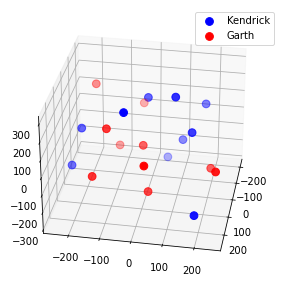

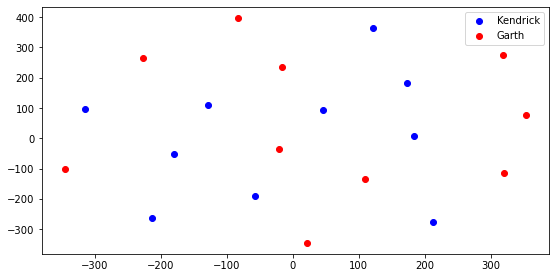

In [89]:
kendrick_3d = transformed_data_3d[:10]
k3_x = [i[0] for i in kendrick_3d]
k3_y = [i[1] for i in kendrick_3d]
k3_z = [i[2] for i in kendrick_3d]

garth_3d = transformed_data_3d[10:]
g3_x = [i[0] for i in garth_3d]
g3_y = [i[1] for i in garth_3d]
g3_z = [i[2] for i in garth_3d]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(k3_x, k3_y, k3_z, c='b', s=60, label='Kendrick')
ax.scatter(g3_x, g3_y, g3_z, c='red', s=60, label='Garth')
ax.view_init(30, 10)
ax.legend()
plt.show()

kendrick_2d = transformed_data_2d[:10]
k2_x = [i[0] for i in kendrick_2d]
k2_y = [i[1] for i in kendrick_2d]

garth_2d = transformed_data_2d[10:]
g2_x = [i[0] for i in garth_2d]
g2_y = [i[1] for i in garth_2d]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(222)
ax.scatter(k2_x, k2_y, c='b', label='Kendrick')
ax.scatter(g2_x, g2_y, c='red', label='Garth')
ax.legend()
plt.show()

Interesting! Take a crack at interpreting these graphs by answering the following questions below:

What does each graph mean? Do you find one graph more informative than the other? Do you think that this method shows us discernable differences between Kendrick Lamar songs and Garth Brooks songs?  Use the graphs and your understanding of TF-IDF to support your answer.  

Write your answer to this question below this line:
________________________________________________________________________________________________________________________________

    I don't see a trend in the red and blue dots in the 2d plot, but the 3d plot it looks like there is some separation.
    
Both graphs show a basic trend among the red and blue dots, although the 3-dimensional graph is more informative than the 2-dimensional graph. We see a separation between the two artists because they both have words that they use, but the other artist does not. The words in each song that are common to both are reduced to very small numbers or to 0, because of the log operation in the IDF function.  This means that the elements of each song vector with the highest values will be the ones that have words that are unique to that specific document, or at least are rarely used in others.  

## Summary

In this lab, you learned how to: 
* Tokenize a corpus of words and identify the different choices to be made while parsing them 
* Use a count vectorization strategy to create a bag of words
* Use TF-IDF vectorization with multiple documents to identify words that are important/unique to certain documents
* Visualize and compare vectorized text documents